First we get all the imports we need to do some data discovery.

In [1]:
import pandas as pd
from pandas.plotting import scatter_matrix
import numpy as np

import matplotlib
import matplotlib.pyplot as plt

import re

# import altair and allow jupyter notebook to see it
import altair as alt
alt.enable_mime_rendering()

In [2]:
# load up the train and test dataset
train = pd.read_csv('train.csv', index_col='PassengerId')
test = pd.read_csv('test.csv', index_col='PassengerId')

# we make these into a list of dataframes so we can
# transform the data together. typically these would be in one
# dataframe and we would split it at the end (before training)
fullData = [train, test]

In [3]:
# First simple thing to do is take a look at the data
# using the pandas describe function on the dataframe
# we say specify we want all types of datatypes
# excluding this param will just give description on
# columns

train.describe(include='all')

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,"Ali, Mr. William",male,NaN,NaN,NaN,347082,NaN,G6,S
freq,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


We start by looking to clean the data. We will remove **NaNs** as needed and changing any non-numeric value to numeric ones.

In [4]:
# we take a look the df to look at 
# all the rows that contain at least one Nan
# how many rows do we have NaN's in?
train[train.isnull().any(axis=1)].count()

Survived    708
Pclass      708
Name        708
Sex         708
Age         531
SibSp       708
Parch       708
Ticket      708
Fare        708
Cabin        21
Embarked    706
dtype: int64

In [5]:
# So it looks like a significant portion
# 708/891 have some sort of NaN
# So the next natural question is which
# columns have the most NaN's and should
# we just get rid of them?

train.isnull().sum()

Survived      0
Pclass        0
Name          0
Sex           0
Age         177
SibSp         0
Parch         0
Ticket        0
Fare          0
Cabin       687
Embarked      2
dtype: int64

In [6]:
# It seems that a majority of cabin is empty
# moreover, I don't know what to make of the string
# so I will get rid of Cabin and Ticket

# Remember, because our training set and test set
# are in separate df's we have to iterate thru fullData
# and apply all our changes from training into test
# right now, we are doing that for train but we have to go
# back and do it for all the iterators in fullData
train = train.drop(columns=['Cabin', 'Ticket'])
train.head()


# when you iterate thru a list and change the iterator
# it does not change the actual list so we use enumerate
# to pass the index and value and use those

# for idx, val in enumerate(fullData):
#     fullData[idx] = val.drop(columns=['Cabin', 'Ticket'])
# fullData[0].head()

#Let start actually cleaning the data
#(wtf. click on shift+tab for a help)
#lets get rid of "Cabin"
# fullData[0]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
PassengerId,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,7.2500,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,71.2833,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,7.9250,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,53.1000,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,8.0500,S


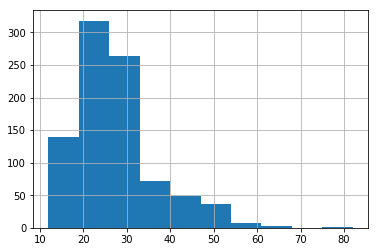

In [15]:
# Now let's start cleaning up the data from left to right. 
# we start with names.
# here lets try to grab any useful information.
# it is obvious that the name of the person did nothing to affect
# their chance of survival (although maybe the length of the name indicates
# rich you are...)
# so the main thing we are going to do is grab the title from the name
# and the length of the name

# we define a function that will use regex to grab
# a title if it exists in the name
def get_title(name):
    # if title exists, extract and return it
    title_search = re.search(' ([A-Za-z]+)\.', name)
    if title_search:
        return title_search.group(1)
    return ""
    
# we apply the function above and take a look at
# (1) the distribution of length of the names and
# (2) the unique titles and its count
train["Title"] = train["Name"].apply(get_title)
train["NameLength"] = train["Name"].apply(len)
train["Name"].apply(len).hist()

In [17]:
train.groupby("Title").count()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,NameLength
Title,,,,,,,,,,
Capt,1,1,1,1,1,1,1,1,1,1
Col,2,2,2,2,2,2,2,2,2,2
Countess,1,1,1,1,1,1,1,1,1,1
Don,1,1,1,1,1,1,1,1,1,1
Dr,7,7,7,7,6,7,7,7,7,7
Jonkheer,1,1,1,1,1,1,1,1,1,1
Lady,1,1,1,1,1,1,1,1,1,1
Major,2,2,2,2,2,2,2,2,2,2
Master,40,40,40,40,36,40,40,40,40,40


In [8]:
# lets group everything count < 10 into Rare
train['Title'] = train['Title'].replace(['Lady', 'Countess', 'Capt', 'Col',
                                         'Don', 'Dr', 'Major', 'Rev',
                                         'Sir', 'Jonkheer', 'Dona'],
                                        'Rare')

# finally, we group the rest of the titles as needed
train['Title'] = train['Title'].replace(['Mlle','Ms'], 'Miss')
train['Title'] = train['Title'].replace(['Mme'], 'Mrs')

# okay, lets take a look at it now
train.groupby("Title").count()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
Title,,,,,,,,,
Master,40,40,40,40,36,40,40,40,40
Miss,185,185,185,185,149,185,185,185,184
Mr,517,517,517,517,398,517,517,517,517
Mrs,126,126,126,126,109,126,126,126,125
Rare,23,23,23,23,22,23,23,23,23


In [20]:
# lets now map the title to numbers as
# 1: Mr
# 2: Miss
# 3: Mrs
# 4: Master
# 5: Rare
title_mapping = {"Mr": 1, "Miss": 2, "Mrs" : 3, "Master" : 4, "Rare" : 5}
train["Title"] = train["Title"].map(title_mapping)
# train["Title"] = train["Title"].fillna(0)

#next we map the male and female as well
train["Sex"] = train["Sex"].map({"male":1, "female":2})

# and the embark
# train['Embarked'] = train['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

In [24]:
train.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",1,22.0,1,0,A/5 21171,7.2500,NaN,S,1
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",2,38.0,1,0,PC 17599,71.2833,C85,C,3
3,1,3,"Heikkinen, Miss. Laina",2,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,2
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",2,35.0,1,0,113803,53.1000,C123,S,3
5,0,3,"Allen, Mr. William Henry",1,35.0,0,0,373450,8.0500,NaN,S,1


In [ ]:
train['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)